In [7]:
import json
import pandas as pd
import matplotlib as mp
# for language detection
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from pathlib import Path
import re
import matplotlib as plt
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from urllib.parse import urlparse
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def repetitiveness_score(text, n=3):
    """
    Split text to n-grams, count duplicates and divided by total n-gram count
    """

    words = text.split()
    if len(words) < n:
        return 0.0
    ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    counts = Counter(ngrams)
    total = len(ngrams)
    repeated = sum(v for v in counts.values() if v > 1)
    return repeated / total

def count_html_tags(text):
    """
    simple regex to get a general sense of the amt of html tags in text
    """
    TAG_REGEX = re.compile(r"<\s*/?\s*([a-zA-Z0-9]+)[^>]*>") # general to match html tags
    return len(TAG_REGEX.findall(text))

def count_non_utf8_chars(text):
    """
    Return count of characters which cant be encoded to utf8
    """
    count = 0
    for c in text:
        try:
            c.encode('utf-8')
        except UnicodeEncodeError:
            count += 1
    return count

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "Unknown"

# Data import

In [9]:
filepath = "../../data/raw/mainpipe_data_v1.jsonl"
data = []

with open(filepath, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(data)
print(df)

                                                     text  \
0       In the never ending battle to rid Alaska of it...   
1       » Jackpot | Deutsche Online Casinos und Casino...   
2       This really was an unexpected pleasure. When I...   
3       def files(self):\n        """Files in torrent....   
4       Patient engagement in the design and delivery ...   
...                                                   ...   
269373  Our 1 to 1 Karting lessons are ideal to give y...   
269374  function read(model) {\n  var query = argument...   
269375  In a land that is already fragile with earthqu...   
269376                                  Simple, YES on 8!   
269377  <p>How would I be able to get N results for se...   

                                                      url  
0                                                    None  
1         http://www.casinodeutsch.net/stichwort/jackpot/  
2       http://leekat.booklikes.com/post/608842/an-une...  
3       https://github.com/

# Data exploration

## Initial noisy text data exploration
Initially for this task I wanted to look into whats normally considered noisy data for LLM preprocessing.
* Null/Na records
* Html tags
* Special and non-utf8 characters

In [4]:
print(f"The number of null text records is {int(df['text'].isnull().sum())}")
print(f"The number of null url records is {int(df['url'].isnull().sum())}")

# Looking into html tags
df["element_count"] = df["text"].apply(count_html_tags)
print(f"The approximate number of records containing html elements is {int(len(df[df['element_count'] > 0 ]))}")

# Looking into non-utf8 rows
df["nonutf8_count"] = df["text"].apply(count_non_utf8_chars)
print(f"The approximate number of records containing non-utf8 characters is {int(len(df[df['nonutf8_count'] > 0 ]))}")

The number of null text records is 0
The number of null url records is 90519
The approximate number of records containing html elements is 65807
The approximate number of records containing non-utf8 characters is 0


## Dataset content exploration
I wanted an idea of the kind of content the datset contained, looking into sources trying to classify content.
* Data sources
* Languages
* Content (code vs formal english vs informal)

Notably github made up a large portion of the sources, the rest of the top 20 sources were mostly news websites. I expected the data to be a strong mix of informal language, formal and code.
There is a large number of items with no url, more on this later.

In [7]:
# Using the base of the url to tell the source
df['base_url'] = df['url'].apply(lambda x: f"{urlparse(x).scheme}://{urlparse(x).netloc}")
df['base_url'].value_counts().head(20)

base_url
b''://b''                            90519
https://github.com                   71415
https://www.taiwannews.com.tw         2583
https://en.wikipedia.org              2326
https://placeholder.co                2110
https://sample-company.net            1997
https://example.com                   1991
https://testsite.org                  1964
https://demo-page.info                1938
http://abcnews.go.com                 1771
http://www.nigeriatoday.ng            1290
https://www.yahoo.com                  946
https://www.nigeriatoday.ng            872
http://www.israelnationalnews.com      746
https://www.nytimes.com                735
http://www.wafb.com                    650
http://uproxx.com                      624
http://newyork.cbslocal.com            463
https://www.engadget.com               452
http://www.taiwannews.com.tw           447
Name: count, dtype: int64

Using regex to get an idea of how much of the dataset is code (26%)

In [8]:
# use some very basic regex to get a sense of what text might be code
df['programming_text'] = df['text'].str.startswith(('def', 'function'))
print(f"The approximate number of records which are code are {int(df['programming_text'].sum())}")

The approximate number of records which are code are 70603


### Exploring languages

In [23]:
# Looking at the languages in the text data using langdetect
df['language'] = df['text'].apply(detect_language)

In [24]:
df['language'].value_counts()

language
en         244566
de          10300
es           8626
fr           1488
ca           1257
da            875
it            265
sv            258
ro            253
no            247
nl            243
af            185
pt            112
cy             94
Unknown        92
ru             79
so             70
id             51
sq             48
tl             43
et             36
sk             25
pl             23
fi             21
hr             18
uk             17
tr             15
sl             15
vi             14
lt             10
hu              9
bg              7
sw              7
lv              4
cs              2
mk              2
he              1
Name: count, dtype: int64

In terms of language, English makes up approximately 93% of records.

## N-gram analysis

In [9]:
# word counts per text
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

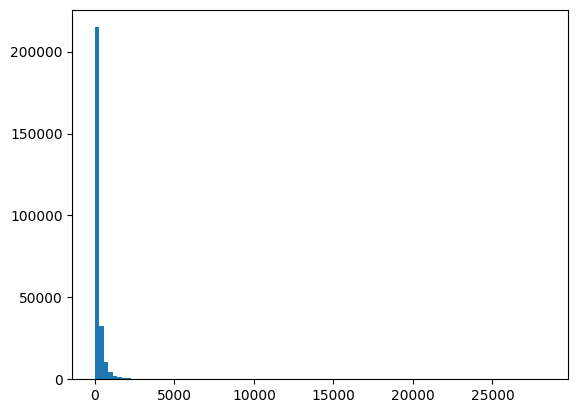

In [10]:
# Looking into word count distribution
plt.pyplot.hist(df['word_count'], bins=100)
plt.pyplot.show()

This doesn't really say a lot about the text, however we can tell there are some large word count outliers
Log scale frequency used below for a better visualisation of word lengths

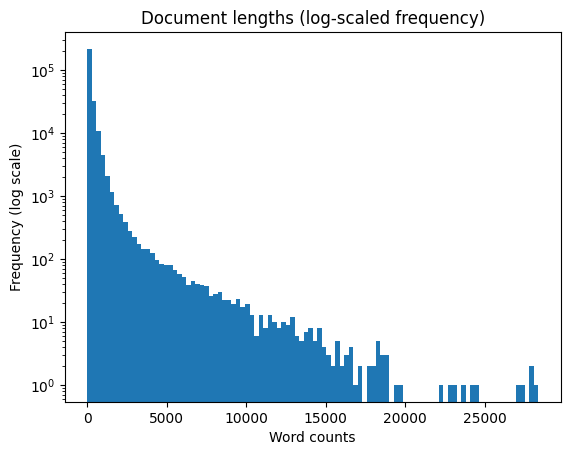

In [11]:
# Visualise word counts
plt.pyplot.hist(df['word_count'], bins=100)
plt.pyplot.yscale('log')  # log scale on Y-axis (frequency)
plt.pyplot.xlabel("Word counts")
plt.pyplot.ylabel("Frequency (log scale)")
plt.pyplot.title("Document lengths (log-scaled frequency)")
plt.pyplot.show()

Based on the histogram above the very long text records sit above 20,000 words

In [42]:
# Breif look into this data
long_docs = df[df['word_count'] > 15000]
long_docs

,text,url,element_count,nonutf8_count,base_url,programming_text,word_count,mean_word_length,hash_count,ellipsis_count,hash_ratio,ellipsis_ratio,symbol_ratio
5483,"Babe Ruth\n\nGeorge Herman ""Babe"" Ruth (Februa...",https://en.wikipedia.org/wiki/Babe%20Ruth,0,0,https://en.wikipedia.org,False,15734,4.795729,0,0,0.000000,0.000000,0.000000
11830,Vigo P De Peliculasxxx Pelicula Escorts Necesi...,https://newtasteofhalal.com/vigo-p-de-pelicula...,0,0,https://newtasteofhalal.com,False,24595,5.608050,50,0,0.002033,0.000000,0.002033
12398,Lesbien Porn Pareja Homosexual Montillón De Ab...,http://sexcamhoertjes.net/lesbien-porn-pareja-...,0,0,http://sexcamhoertjes.net,False,15368,5.841554,0,0,0.000000,0.000000,0.000000
16952,SENTENCIA dictada en la Controversia Constituc...,http://dof.gob.mx/nota_detalle.php?codigo=5052...,0,0,http://dof.gob.mx,False,23793,5.330854,0,0,0.000000,0.000000,0.000000
17045,Cortijada El Secano Masaje Erotico Cadiz Video...,http://poulettesurlenet.com/cortijada-el-secan...,0,0,http://poulettesurlenet.com,False,16519,5.696955,0,0,0.000000,0.000000,0.000000
22091,Decreto Municipal 1521 de 2008 by FAUPB taller...,https://issuu.com/faupb-taller8/docs/decreto15...,0,0,https://issuu.com,False,28356,5.294365,0,3,0.000000,0.000106,0.000106
32406,Memoria del Festival Internacional de Musica y...,https://issuu.com/manigua/docs/fmyd_10_memoria...,0,0,https://issuu.com,False,24247,5.130490,0,0,0.000000,0.000000,0.000000
33108,Augustin-Jean Fresnel\n\nAugustin-Jean Fresnel...,https://en.wikipedia.org/wiki/Augustin-Jean%20...,0,0,https://en.wikipedia.org,False,18887,5.359401,0,8,0.000000,0.000424,0.000424
33727,Videos Pareja Mas Para Y Caserío Hentai Mejore...,https://talkinggenerationnext.com/videos-parej...,0,0,https://talkinggenerationnext.com,False,22748,5.652145,0,0,0.000000,0.000000,0.000000
42036,Pasivo Videos Peliculas Xxx Gratis Milady Desn...,https://europeanfollies.com/pasivo-videos-peli...,0,0,https://europeanfollies.com,False,22174,5.574457,0,0,0.000000,0.000000,0.000000


The very long docs are mostly non-english language.
Interestingly a lot of the very long docs look like adult content. It's good to know this exists in the data as we can focus on filtering it out in the detoxification step.

### Short docs
- Generally text data preproccessing involves filtering out low word-count text as it often doesn't contain linguistic context

In [32]:
short_docs = df[df['word_count'] < 30]
short_docs

,text,url,element_count,nonutf8_count,base_url,programming_text,word_count,mean_word_length
11,Very Cool.,None,0,0,b''://b'',False,2,4.500000
18,"def friendly_name(self):\n """"""Get frien...",https://github.com/happyleavesaoc/python-snapc...,0,0,https://github.com,True,11,16.090909
21,function mouseout(inEvent) {\n if (!this.isEv...,https://github.com/openlayers/openlayers/blob/...,0,0,https://github.com,True,15,10.333333
36,I applaud Civil's efforts to create some new t...,None,0,0,b''://b'',False,19,5.631579
48,"<!doctype html><html lang=""en""><head><title>Ab...",https://example.com/page12.html,25,0,https://example.com,False,14,20.071429
...,...,...,...,...,...,...,...,...
269348,function writeCommentExt() {\n out.writeByt...,https://github.com/abagames/gif-capture-canvas...,0,0,https://github.com,True,22,9.409091
269358,"def xrify_tuples(self, tup):\n """"""Make ...",https://github.com/pytroll/trollimage/blob/d35...,0,0,https://github.com,True,12,11.333333
269364,"<html><head><meta charset=""utf-8""><title>Blog ...",https://example.com/page13.html,17,0,https://example.com,False,16,15.812500
269375,In a land that is already fragile with earthqu...,None,0,0,b''://b'',False,26,4.307692


In [29]:
# Checking how many docs of less than 50 words are because they are code
df_short_and_code = short_docs[short_docs['programming_text']==True]
df_short_and_code

,text,url,element_count,nonutf8_count,base_url,programming_text,word_count
3,"def files(self):\n """"""Files in torrent....",https://github.com/idlesign/torrentool/blob/78...,0,0,https://github.com,True,43
12,"def list_friends(self, delegate, user=None, pa...",https://github.com/dustin/twitty-twister/blob/...,0,0,https://github.com,True,43
18,"def friendly_name(self):\n """"""Get frien...",https://github.com/happyleavesaoc/python-snapc...,0,0,https://github.com,True,11
21,function mouseout(inEvent) {\n if (!this.isEv...,https://github.com/openlayers/openlayers/blob/...,0,0,https://github.com,True,15
22,"def make_filter_list(filters):\n """"""Transfo...",https://github.com/dfm/python-fsps/blob/29b81d...,0,0,https://github.com,True,40
...,...,...,...,...,...,...,...
269343,"def _lookup_consumer_tag_by_consumer(self, con...",https://github.com/agoragames/haigha/blob/7b00...,0,0,https://github.com,True,48
269344,"function fromFreq (freq, tuning) {\n tuning =...",https://github.com/danigb/music-pitch/blob/2f2...,0,0,https://github.com,True,29
269346,"function checkSpacingAfter(token, pattern) {\n...",https://github.com/eslint/eslint/blob/bc0819c9...,0,0,https://github.com,True,9
269348,function writeCommentExt() {\n out.writeByt...,https://github.com/abagames/gif-capture-canvas...,0,0,https://github.com,True,22


### mean word length

In [23]:
df['mean_word_length'] = (
    df['text']
    .str.split()  # split text into words
    .apply(lambda words: sum(len(w) for w in words) / len(words) if len(words) > 0 else 0)
)

In [27]:
low_mean_word_length = df[df['mean_word_length']< 3]
low_mean_word_length.head(20)

,text,url,element_count,nonutf8_count,base_url,programming_text,word_count,mean_word_length
549,OK,None,0,0,b''://b'',False,1,2.000000
2160,"function norm16(v) {\n v = parseInt(v, 16);...",https://github.com/dbkaplun/hterm-umdjs/blob/5...,1,0,https://github.com,True,41,2.560976
3627,"def erank(self):\n """""" Effective rank o...",https://github.com/oseledets/ttpy/blob/b440f62...,0,0,https://github.com,True,87,2.770115
3829,+1,None,0,0,b''://b'',False,1,2.000000
5415,<pre><code>sub foo {[$#{$_[!$||$|]}*@{$_[!!$_^...,None,38,0,b''://b'',False,826,2.801453
6524,"function cpy32 (d, s) {\n for (var i = ...",https://github.com/Toxiapo/ardorjs/blob/0e3127...,0,0,https://github.com,True,18,2.777778
6754,OK,None,0,0,b''://b'',False,1,2.000000
6922,I C.,None,0,0,b''://b'',False,2,1.500000
6935,function whiteOrBlack( color ) {\n\t\tcolor = ...,https://github.com/skerit/alchemy-styleboost/b...,0,0,https://github.com,True,77,2.792208
7009,+1,None,0,0,b''://b'',False,1,2.000000


### Symbol ratios

In [33]:
# Count occurrences of hash (#) and ellipsis (…)
df["hash_count"] = df["text"].str.count("#")
df["ellipsis_count"] = df["text"].str.count("…")

# Calculate ratios (symbols per word)
df["hash_ratio"] = df["hash_count"] / df["word_count"]
df["ellipsis_ratio"] = df["ellipsis_count"] / df["word_count"]

# If you want an overall combined ratio:
df["symbol_ratio"] = (df["hash_count"] + df["ellipsis_count"]) / df["word_count"]

In [38]:
high_symbols = df[df['symbol_ratio'] > 0.1]
high_symbols

,text,url,element_count,nonutf8_count,base_url,programming_text,word_count,mean_word_length,hash_count,ellipsis_count,hash_ratio,ellipsis_ratio,symbol_ratio
521,<p>I want to see all the different ways you ca...,None,90,0,b''://b'',False,415,14.053012,92,0,0.221687,0.000000,0.221687
934,<p>Is there a built in way to convert an integ...,None,46,0,b''://b'',False,98,9.938776,10,0,0.102041,0.000000,0.102041
1331,def create_sheet(self):\n '''\n ...,https://github.com/PmagPy/PmagPy/blob/c7984f88...,0,0,https://github.com,True,248,10.157258,25,0,0.100806,0.000000,0.100806
2706,Local Mexican Restaurant Review\n\nTijuana Fla...,http://wfuogb.com/2018/02/local-mexican-restau...,0,0,http://wfuogb.com,False,644,4.923913,0,85,0.000000,0.131988,0.131988
3609,"<p>What are these PC533, PC667, or PC### etc</...",None,10,0,b''://b'',False,85,4.682353,9,0,0.105882,0.000000,0.105882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266206,"def warn_if_insecure_platform():\n """"""\n ...",https://github.com/onecodex/onecodex/blob/326a...,0,0,https://github.com,True,138,6.811594,202,0,1.463768,0.000000,1.463768
266283,<pre><code>#if SYMBOL\n //code\n#endif\n</cod...,None,16,0,b''://b'',False,45,7.666667,5,0,0.111111,0.000000,0.111111
266470,#BlackLivesMatter,None,0,0,b''://b'',False,1,17.000000,1,0,1.000000,0.000000,1.000000
268098,Well done Gov. Walker… now let’s build a road ...,None,0,0,b''://b'',False,12,4.000000,0,2,0.000000,0.166667,0.166667


### Uni-grams

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')
X = vectorizer.fit_transform(df['text'])
counts = np.array(X.sum(axis=0)).flatten()
bigrams = pd.DataFrame({'bigram': vectorizer.get_feature_names_out(), 'count': counts})

,bigram,count
276997,code,203010
620635,la,160383
381438,en,159402
375135,el,125171
878183,return,116946
923667,self,113791
637156,li,113375
844913,que,111289
735863,new,109092
339481,die,108776


In [20]:
bigrams.sort_values('count', ascending=False).head(30)

,bigram,count
276997,code,203010
620635,la,160383
381438,en,159402
375135,el,125171
878183,return,116946
923667,self,113791
637156,li,113375
844913,que,111289
735863,new,109092
339481,die,108776


### Bi grams

In [23]:
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(df['text'])
counts = np.array(X.sum(axis=0)).flatten()
bigrams = pd.DataFrame({'bigram': vectorizer.get_feature_names_out(), 'count': counts})

In [24]:
bigrams.sort_values('count', ascending=False).head(30)

,bigram,count
8093607,href http,48357
9595519,li li,41514
3524203,code pre,37111
13498718,rel nofollow,37084
11208384,nofollow noreferrer,36981
12578092,pre code,35596
8109386,http www,28514
5753174,en el,19682
7563786,gt lt,18609
5756114,en la,16469


### Repetitiveness of n-grams

In [11]:
df['repetitiveness'] = df['text'].apply(lambda t: repetitiveness_score(t, n=3))

In [12]:
repetitive = df[df['repetitiveness']>0.8]
repetitive

,text,url,repetitiveness
871,Home | Products | About | Contact | Login | Si...,None,1.000000
904,At The San Diego Padres Shop you can find gear...,https://www.padresteamshoponline.com/Nate_Colb...,0.814286
920,Home | Products | About | Contact | Login | Si...,None,1.000000
1047,"I don’t normally watch such movies, but I like...",https://tuetego.net/article/aeon-flux-a-2005-m...,0.992754
2197,Home | Products | About | Contact | Login | Si...,None,1.000000
...,...,...,...
267867,Home | Products | About | Contact | Login | Si...,None,1.000000
267960,Trump to herald 'New American Moment' for US a...,https://www.taiwannews.com.tw/en/news/3354528,0.844444
268072,President Trump says US troops will be coming ...,https://www.taiwannews.com.tw/en/news/3413391,0.820513
268083,Epidemiología de la muerte súbita cardiaca [Re...,https://medes.com/publication/80540,0.876543


### no stopword records

In [55]:
stops = set(stopwords.words('english'))

# Flag rows with no stopwords
df['no_stopwords'] = df['text'].apply(
    lambda x: not any(word.lower() in stops for word in x.split())
)

In [60]:
df[df['no_stopwords'] == True]

,text,url,element_count,nonutf8_count,base_url,programming_text,word_count,mean_word_length,hash_count,ellipsis_count,hash_ratio,ellipsis_ratio,symbol_ratio,repetitiveness,no_stopwords
35,"function traverse(transform, node, parent) {\n...",https://github.com/bem-contrib/md-to-bemjson/b...,0,0,https://github.com,True,59,8.576271,0,0,0.0,0.0,0.0,0.00000,True
90,function mayProxy (pathname) {\n const mayb...,https://github.com/vuejs/vue-cli/blob/206803cb...,0,0,https://github.com,True,12,11.083333,0,0,0.0,0.0,0.0,0.00000,True
129,Estás aquí: Inicio/Reparaciones/Reparaciones i...,https://www.reparamosiphone.com/blog/productos...,0,0,https://www.reparamosiphone.com,False,25,5.720000,0,0,0.0,0.0,0.0,0.26087,True
131,function getMarkDownItAnchorId (text) {\n tex...,https://github.com/commenthol/markedpp/blob/f7...,0,0,https://github.com,True,24,8.291667,0,0,0.0,0.0,0.0,0.00000,True
134,function endActivity(activityId) {\n markActi...,https://github.com/hswolff/activity-logger/blo...,0,0,https://github.com,True,13,11.923077,0,0,0.0,0.0,0.0,0.00000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269307,"function(fn, testSelf) {\n return Y.one...",https://github.com/5long/roil/blob/37b14072a7a...,0,0,https://github.com,True,8,10.500000,0,0,0.0,0.0,0.0,0.00000,True
269323,function ContactsGroupsPermissionsDelete(optio...,https://github.com/smsapi/smsapi-javascript-cl...,0,0,https://github.com,True,14,10.500000,0,0,0.0,0.0,0.0,0.00000,True
269344,"function fromFreq (freq, tuning) {\n tuning =...",https://github.com/danigb/music-pitch/blob/2f2...,0,0,https://github.com,True,29,5.448276,0,0,0.0,0.0,0.0,0.00000,True
269346,"function checkSpacingAfter(token, pattern) {\n...",https://github.com/eslint/eslint/blob/bc0819c9...,0,0,https://github.com,True,9,11.444444,0,0,0.0,0.0,0.0,0.00000,True


### Testing toxicity

In [4]:
with open('../../data/raw/en.txt', 'r', encoding='utf-8') as f:
    bad_words = [line.strip() for line in f if line.strip()]

# Compile a regex pattern for whole word matches, case-insensitive
pattern = re.compile(r'\b(' + '|'.join(map(re.escape, bad_words)) + r')\b', flags=re.IGNORECASE)

# Function to flag inappropriate content
def flag_inappropriate(text):
    return bool(pattern.search(text))

# Apply to the dataframe
df['is_inappropriate'] = df['text'].apply(flag_inappropriate)

In [5]:
df[df['is_inappropriate']==True]

,text,url,is_inappropriate
106,Herren Skihandschuhe Vergleich - die besten Pr...,https://clean-winners.de/herren-skihandschuhe-...,True
166,Elcometer: Tablas de Prueba Leneta\nProductos ...,http://elcometer.com.mx/aplicacion/Elcometer_4...,True
222,<p>I can't seem to figure out a good way to do...,None,True
239,"Cámara Domo Meriva MBAS500, 650TVL 12X ZOO c/ ...",http://www.pcdigital.com.mx/product_info.php/c...,True
265,15.11.2018 numeros de prostitutas en tarragona...,https://expertforum.info/Videos-con-putas/nume...,True
...,...,...,...
269167,Leave it to Nigel Jaquiss to write this trash ...,None,True
269190,More questions than answers in death of North ...,http://abcnews.go.com/International/wireStory/...,True
269235,Siempre : 01/01/2010 - 02/01/2010\nAcababa de ...,http://alfonsoillas.blogspot.com/2010/01/,True
269254,"Marines seek young, tough recruits in Super Bo...",http://www.wafb.com/story/37418771/marines-see...,True
